In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report
from modeling import optimize, train, evaluate, preprocess, plot_score_comparison
from itertools import product
import seaborn as sns
np.random.seed(42)

In [2]:
df = pd.read_csv('data/processed/clean_and_filled.csv')

`types` is a dataframe containing all features available on the dataset and a respective feature type belonging to one of the following:
- `G` - Genetic/Intrinsic feature (uncontrollable fetures like sex and age)
- `E` - Environmental/Behavioural feature (features that can be controlled, even if slightly, like blood sugar and smoking)
- `H` - Information based on medical history (purely historical information, like previous episodes of chest pain)
- `T` - Test result (tests that require any kind of medical equipment like blood pressure monitors)
- `TP` - Test parameter (condition under which a test has been conducted)
- `CT` - "Cheap" test (tests or checks that can be performed without specific medical equipment)



In [3]:
types = pd.read_csv('data/processed/feature_types.csv').dropna()

In [4]:
for group in types.groupby('feature_type').groups:
    print(types.groupby('feature_type').get_group(group))
    print()

           feature feature_type
3  cp_type_no_pain            ?

               feature feature_type
33  blood_press_s_rest           CT
48     heart_rate_peak           CT
49     heart_rate_rest           CT
53           ex_angina           CT

                feature feature_type
34                 chol            E
35               smoker            E
36  smoker_cigs_per_day            E
37         smoker_years            E
38  fasting_blood_sugar            E

                 feature feature_type
0                  sex_F            G
1                  sex_M            G
29                   age            G
39  heart_disease_family            G

                   feature feature_type
2  cp_type_atypical_angina            H
4      cp_type_non_anginal            H
5   cp_type_typical_angina            H

                               feature feature_type
6                 rest_ecg_hypertrophy            T
7                      rest_ecg_normal            T
8               rest_ec

In [5]:
model_constructor = RandomForestClassifier

# Question 2
Do genetic/instrinsic factors play a larger role than environmental/behavioral ones?

In [6]:
genetic_cols = list(types.groupby('feature_type').get_group('G')['feature']) 
environmental_cols = list(types.groupby('feature_type').get_group('E')['feature']) 

Training models...: 100%|██████████| 120/120 [00:18<00:00,  6.36it/s]


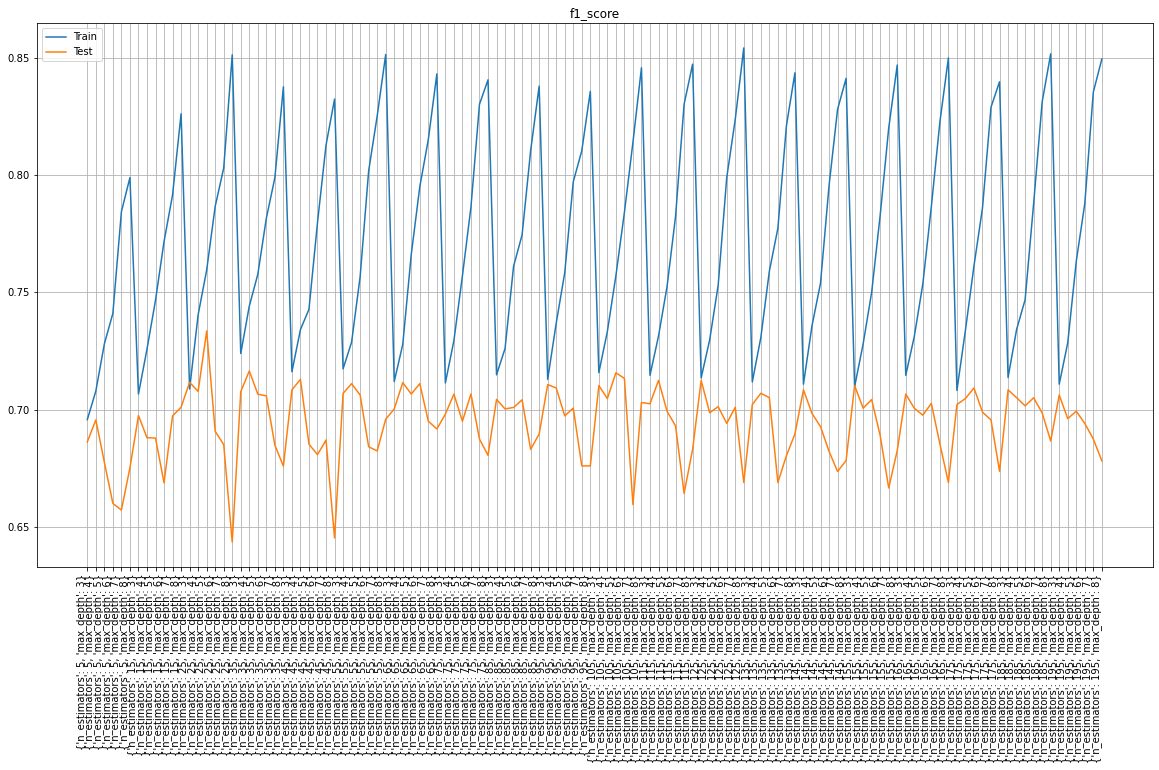

In [7]:
env_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
env_model, env_training, env_score, env_param = optimize(df[environmental_cols + ['target']], 0.3, model_constructor, env_params, plot=True)

In [8]:
print(environmental_cols)
env_score

['chol', 'smoker', 'smoker_cigs_per_day', 'smoker_years', 'fasting_blood_sugar']


{'f1_score': 0.7335423197492162,
 'accuracy_score': 0.6851851851851852,
 'precision_score': 0.6802325581395349,
 'recall_score': 0.7959183673469388}

Training models...: 100%|██████████| 120/120 [00:19<00:00,  6.28it/s]


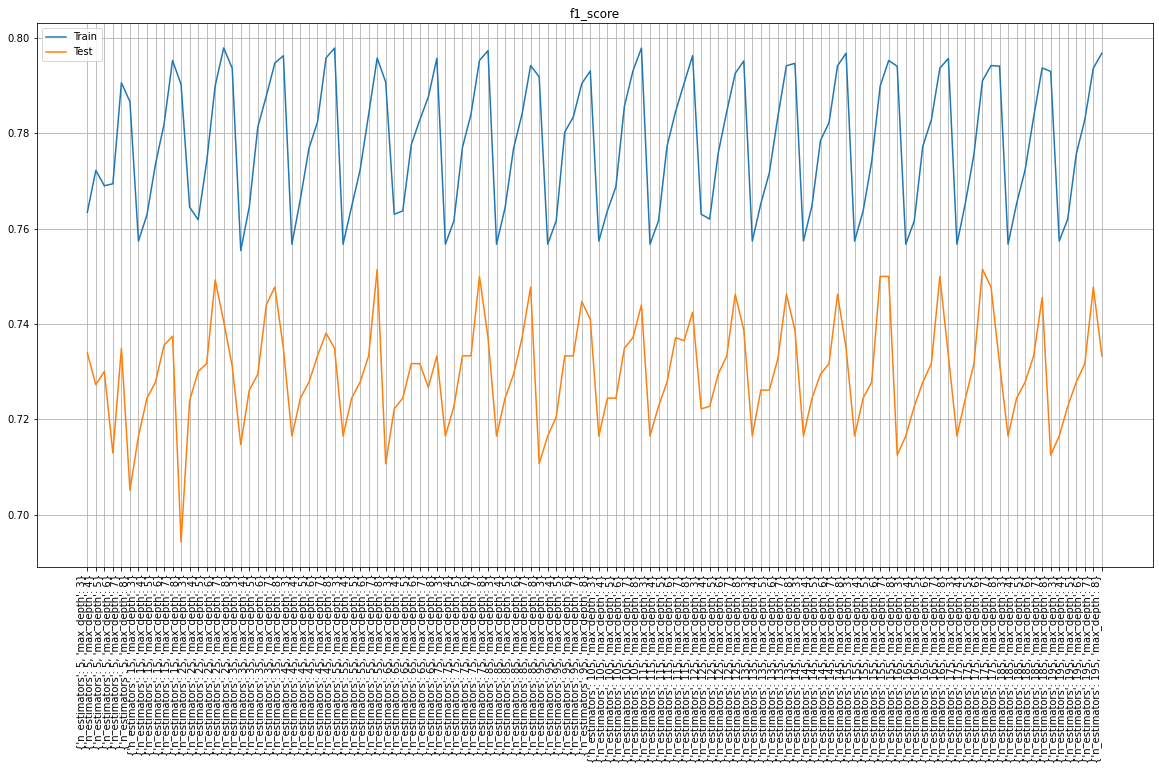

In [9]:
gen_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
gen_model, gen_training, gen_score, gen_param = optimize(df[genetic_cols + ['target']], 0.3, model_constructor, gen_params, plot=True)

In [10]:
print(genetic_cols)
gen_score

['sex_F', 'sex_M', 'age', 'heart_disease_family']


{'f1_score': 0.7514792899408284,
 'accuracy_score': 0.6888888888888889,
 'precision_score': 0.6649214659685864,
 'recall_score': 0.8639455782312925}

                   genetic  environmental
f1_score         75.147929      73.354232
accuracy_score   68.888889      68.518519
precision_score  66.492147      68.023256
recall_score     86.394558      79.591837


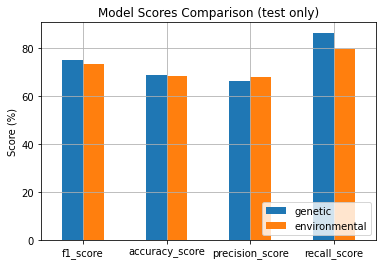

In [11]:
plot_score_comparison([gen_score, env_score], ['genetic', 'environmental'], save_path='data/results/genetic_vs_env_model_scores.png')

## Comparing to our baseline model
The baseline was trained with all the features

In [16]:
from joblib import load
full_model = load('data/results/gb_full-features_model.joblib')
X_train, X_test, y_train, y_test = preprocess(df)
_, full_score = evaluate(full_model, X_train, X_test, y_train, y_test)
full_score

{'f1_score': 0.8646864686468646,
 'accuracy_score': 0.8481481481481481,
 'precision_score': 0.8397435897435898,
 'recall_score': 0.891156462585034}

In [15]:
from joblib import load
full_model = load('data/results/gb_full-features_model.joblib')
X_train, X_test, y_train, y_test = preprocess(df)
_, full_score = evaluate(full_model, X_train, X_test, y_train, y_test)
full_score

C:\Users\guischmitd\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\guischmitd\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\guischmitd\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


{'f1_score': 0.8646864686468646,
 'accuracy_score': 0.8481481481481481,
 'precision_score': 0.8397435897435898,
 'recall_score': 0.891156462585034}

                      full   low_cost
f1_score         86.468647  83.495146
accuracy_score   84.814815  81.111111
precision_score  83.974359  79.629630
recall_score     89.115646  87.755102


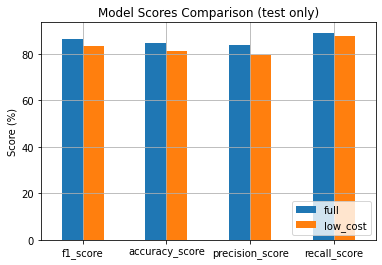

In [30]:
plot_score_comparison([full_score, cheap_score], ['full', 'low_cost'], save_path='data/results/full_vs_low_cost_model_scores.png')